#  Biases in Word2Vec?

_Notebook by Emma Gerritse and Arjen P. de Vries_

## Introduction

_Word Embeddings_ produced by algorithms like Google's Word2Vec (W2V) have quickly become the de facto method to include textual data into analyses, partially because they conveniently summarize varying length character sequences as a fixed series of numbers that can easily serve as input to machine learning approaches, especially those using neural networks.

The paper [Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings](https://arxiv.org/abs/1607.06520) (Bolukbasi et al., 2016) raises the concern that Word Embeddings might exhibit female/male gender stereotypes to a disturbing extent. Is this really true, and, if so, how does that impact intelligent processing of texts using computers?

This notebook briefly reviews Word Embeddings and their role in understanding semantic relations between words. It reproduces the results of the Bolukbasi paper, explores how we may need to be less concerned than the authors of the manuscript have suggested; but, at the same time making clear how difficult it is to avoid or even diagnose bias in text representations learned from large amounts of human information.

## Word Embeddings

Already in the 1950s researchers experimented with different ways to represent text as vectors in high-dimensional spaces. In recent years, the representation produced by Word2Vec [(Mikolov, 2013)](https://arxiv.org/abs/1301.3781) has been a successful component in a huge number of intelligent text processing systems using (deep) neural networks; as an example of how well text can be captured by Word Embeddings produced by W2V and variations like Glove, have some fun with the [Talk to Transformer](https://talktotransformer.com/) text generation demo!

The intuition underlying Word Embeddings is that you feed the computer a huge number of sentences, real text, and give it the objective to predict word occurrence in every sentence using just the information contained in the rest of the sentence, while representing the word as a point in a high dimensional space. _Exactly_ how W2V embeds text in continuous high dimensions is perhaps best explained by Xin Rong's [_word2vec Parameter Learning Explained_](https://arxiv.org/abs/1411.2738) (Rong, 2019). WEVI, the online [wevi: word embedding visual inspector](https://ronxin.github.io/wevi/) is particularly helpful in gaining insight. 

Today, we do not need that level of understanding though - it is enough to know that every word that we encounter will be converted into a series of 300 numbers, in such a way, that a neural network that reads these numbers as input to predict its occurrence (when it is held-out from the data) from its context makes the lowest number of mistakes. We say that the 300-d vector represents the word and its context, and use this vector as a more concise representation than the original texts that it was derived from.

### Pre-trained Word Embeddings

The method to create word embeddings ideally uses large amounts of text data as input - similar to the text that the algorithm should work with. In practice, many researchers (including those from the Bolukbasi paper that warns against bias in Word Embeddings) use _pre-trained_ word embeddings, and a popular choice is the dataset distributed by the authors of the W2V paper who used a large amount of articles from Google News.

We use these [pre-trained Google News Word Embeddings](https://code.google.com/archive/p/word2vec/), provided by Google as research data with their [2013 NIPS paper](https://arxiv.org/abs/1310.4546).

Load the W2V vectors in the `gensim` Python library:

In [82]:
import gensim

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
# Note: loading the embeddings takes around 10 minutes, and we suggest a minimum of 8 GB of ram.
#model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

# Using Memory Mapped files leads to significantly better performance, so save and reload:
#model.save('GN-vectors.bin')

# Load the wordvectors using memory mapped files:
model = gensim.models.KeyedVectors.load('GN-vectors.bin', mmap='r')

### Word Vector Scatter Plots

The pre-trained Word Embeddings are 300-dimensional vectors, not easily interpreted by humans. 

See for example the first 16 values for the word "China", to get an idea: 

In [83]:
# First 16 dimensions of the word vector for China (from 300)
model.get_vector("China")[1:16]

memmap([ 0.13574219,  0.10888672,  0.08300781, -0.12792969, -0.22753906,
         0.15136719, -0.0456543 , -0.06542969,  0.03442383, -0.140625  ,
        -0.02355957,  0.24609375, -0.27148438, -0.1875    , -0.11865234],
       dtype=float32)

To better understand how words are situated in the embedding space and inspect how word vectors relate to each other, we project sets of word vectors onto a 2-dimensional space that we can create figures of; a common method to achieve that is known as Principal Components Analysis (PCA), and the resulting plots are referred to as word vector scatter plots.

The next block of code defines a function `words_pca` to transform word vectors to coordinate pairs:

In [84]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
#import umap
import matplotlib.pyplot as plt

# PCA projection of the word embeddings of a given list of words
#
def words_pca(word_list, transform = 'pca'):
    # Looking up the vectors per word
    bias_vectors = [model[word] for word in word_list]
    # scaling the wordvectors
    bias_vectors = StandardScaler().fit_transform(bias_vectors)
    # applying PCA with 2 components
    if transform == 'pca':
        pca = PCA(n_components=2)
        bias_pca = pca.fit_transform(bias_vectors)
    elif transform == 'tsne':
        bias_pca = TSNE(n_components=2).fit_transform(bias_vectors)
    else:
#       bias_pca = umap.UMAP().fit_transform(bias_vectors)
        bias_pca = []
    return bias_pca
    

The Google NIPS paper argues that Word Embeddings "learn" semantic relationships between words; they show how countries and capitals are situated in the embedding space in a very specific way, such that you can even apply vector arithmetic.

So, let us first create a vector scatter plot of countries and capitals:

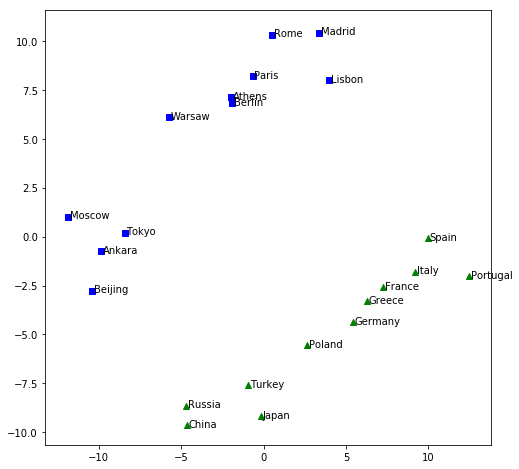

In [85]:
# Countries and Capitals from W2V paper:
countries = ['China', 'Russia', 'Japan', 'Turkey', 'Poland', 'Germany', 'France', 'Italy', 'Greece', 'Spain', 'Portugal']
capitals =  ['Beijing', 'Moscow', 'Tokyo', 'Ankara', 'Warsaw', 'Berlin', 'Paris', 'Rome', 'Athens', 'Madrid', 'Lisbon']

# Projecting on 2D using PCA
words = countries + capitals
ccproj = words_pca(words, transform = 'pca')

plt.figure(figsize=(8,8))
# Plotting the PCA with words
for i,word in enumerate(words):
    x = ccproj[i,0]
    y = ccproj[i,1]
    if word in countries:
        plt.scatter(x, y, marker='^', c='g')
    elif word in capitals:
        plt.scatter(x, y, marker='s', c='b')
    plt.text(x+0.1, y-0.1, word, fontsize=10)
        
plt.show()


You can see that the countries and capitals cluster together, and, you may also have noticed the property that the Google researchers called _compositionality_ of the embeddings: pairs of country and capital seem to have very similar translation vectors. 

If that is indeed the case, we might take one pair of country and capital, compute its translation vector, and apply that to other countries or capitals! Let's check with a few examples:

In [86]:
# Spain - Madrid + Rome
model.most_similar(positive=['Spain','Rome'], negative = ['Madrid'], topn = 1)

[('Italy', 0.7004686594009399)]

In [87]:
# Beijing - China + Japan
model.most_similar(positive=['Beijing','Japan'], negative = ['China'], topn = 1)

[('Tokyo', 0.8115593194961548)]

## Biased Word Vectors?

First, let us look at the examples given in the paper:

In [81]:
print("Most similar to computer_programmer - he + she: \n",model.most_similar(positive = ['computer_programmer', 'she'], negative = ['he'], topn = 5))
print("Most similar to beautician - she + he: \n", model.most_similar(positive = ['beautician', 'he'], negative = ['she'], topn = 5))


Most similar to computer_programmer - he + she: 
 [('homemaker', 0.5700256824493408), ('housewife', 0.5342153906822205), ('businesswoman', 0.5196776390075684), ('saleswoman', 0.5168929696083069), ('graphic_designer', 0.5157608985900879)]
Most similar to beautician - she + he: 
 [('barber', 0.6375421285629272), ('handyman', 0.5406479835510254), ('carpenter', 0.5381854772567749), ('mechanic', 0.526857852935791), ('electrician', 0.5152750015258789)]


We confirm the finding that made it to the paper's title: W2V word embeddings seem to encode that the female equivalent of _computer programmer_ is _homemaker_ or _housewife_!

However, let us not jump to conclusions and consider a few more examples.

In [6]:
print("Most similar to programmer - he + she: \n", model.most_similar(positive = ['programmer', 'she'], negative = ['he'], topn = 5))


Most similar to programmer - he + she: 
 [('programmers', 0.5277910232543945), ('coder', 0.5032480955123901), ('Programmer', 0.5006575584411621), ('graphic_designer', 0.48125559091567993), ('librarian', 0.4702720642089844)]


Replacing the more specific term "computer programmer" by "programmer" suggests no gender bias at all, although we are using the exact same technique as above.

We suspect that the number of occurrences of the term for which we take an embedding might have a large effect on the outcomes. Unfortunately, we do not know much about the corpus that provides the pre-trained Word Embeddings, other than that they are derived from a large corpus of Google News data, in 2013. For the relative frequency of terms to consider, we can try looking at similar sources, e.g., the public information from [Google trends](https://trends.google.com/trends/explore?geo=US&q=computer%20programmer,programmer) might have similar characteristics - but we cannot be certain.

Next, let us investigate whether these analogies hold both ways. If _computer programmer - he + she = homemaker_, does the reverse also hold? What is the result of _homemaker - she + he_ ? 

In [8]:
def analogy_convergence(biassed_word, fromword = 'he', toword = 'she', N = 10):
    firstfrom = fromword
    firstto = toword
    biassed_from = biassed_word
    biassed_to = ""
    for i in range(N):
        analogy = model.most_similar(positive = [biassed_from, toword], negative = [fromword], topn = 1)[0][0]
        print(biassed_from, " - ", fromword, " + ", toword, " = ", analogy)
        if analogy == biassed_to:
            break
        else:
            biassed_to = biassed_from
            biassed_from = analogy
            if i%2 == 0:
                fromword = firstto
                toword = firstfrom
            else:
                fromword = firstfrom
                toword = firstto
    if i == N:
        print("Convergence not reached within ", N, " steps")
        

In [9]:
analogy_convergence('computer_programmer', 'he', 'she')

computer_programmer  -  he  +  she  =  homemaker
homemaker  -  she  +  he  =  carpenter
carpenter  -  he  +  she  =  seamstress
seamstress  -  she  +  he  =  carpenter


In [10]:
analogy_convergence('pizzas', 'he', 'she')

pizzas  -  he  +  she  =  cupcakes
cupcakes  -  she  +  he  =  waffles
waffles  -  he  +  she  =  cupcakes


In [11]:
analogy_convergence('pizza', 'he', 'she')

pizza  -  he  +  she  =  Domino_pizza
Domino_pizza  -  she  +  he  =  pizza


We know about the analogies, but what are the actual similarities between the words?

In [12]:
def word_sim(word1, word2):
    return round(1-spatial.distance.cosine(model[word1], model[word2]),2)

In [13]:
from scipy import spatial
print("Distance between 'he' and 'computer_programmer':", word_sim('he', 'computer_programmer'))
print("Distance between 'she' and 'computer_programmer':",word_sim('she', 'computer_programmer'))
print("Distance between 'he' and 'homemaker':", word_sim('he', 'homemaker'))
print("Distance between 'she' and 'homemaker':",word_sim('she', 'homemaker'))
print("Distance between 'he' and 'she':", word_sim('he', 'she'))

Distance between 'he' and 'computer_programmer': 0.18
Distance between 'she' and 'computer_programmer': 0.19
Distance between 'he' and 'homemaker': 0.13
Distance between 'she' and 'homemaker': 0.4
Distance between 'he' and 'she': 0.61


Note that 'she' is closer to 'computer_programmer' than 'he' is!

In the Bolukbasi et al. paper, they list the following words as most biased in gender. You can optionally add a list of super gendered words by uncommenting  the line after 'optional, add gendered words'. This is to push 'gender' as the principal component. 

In [17]:
super_gendered = ['king', 'queen', 'brother', 'sister', 'mother', 'father',
                  'she', 'woman', 'he', 'man', 'grandpa', 'grandma', 'boy', 'girl',
                 'her', 'his', 'daughter', 'son', 'Mary', 'John']

In [18]:
# setting the plotsize
plt.rcParams['figure.figsize'] = [15, 15]

First to see how gendered word embeddings are, we make plot the vectors. Since 300-dimensional plots are not very intuitive for humans, we need to reduce the dimensionality to two dimensions. There are multiple ways to do this, such as PCA, TSNE and UMAP. First we look at the words which the authors describe as being biassed.

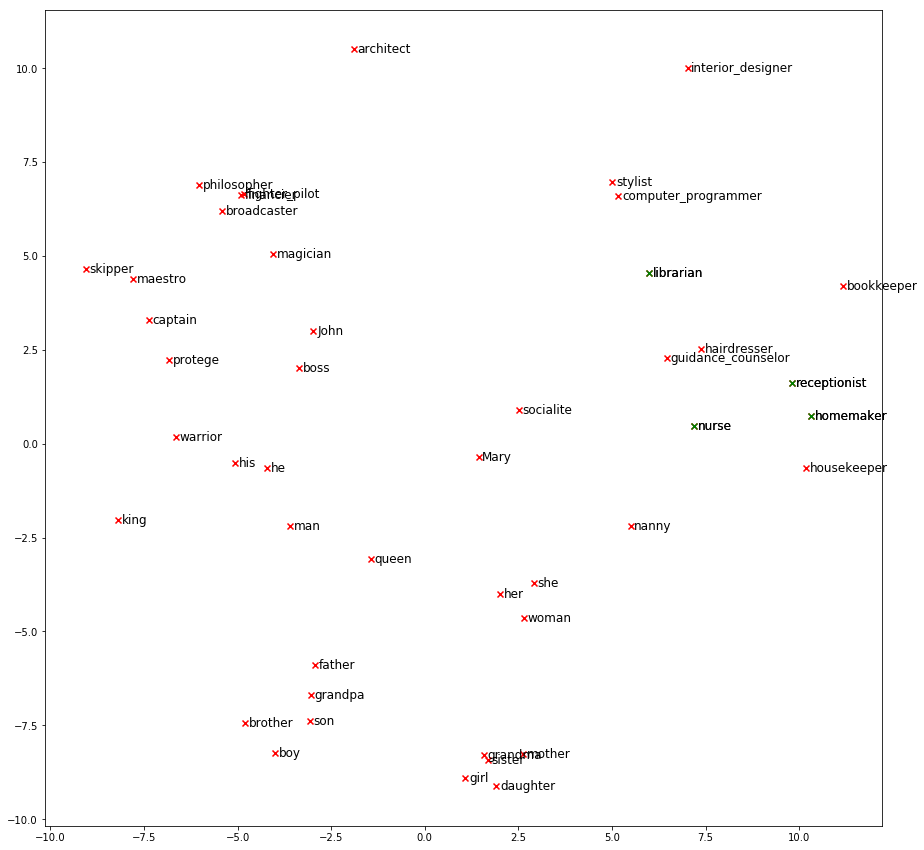

In [27]:
# list of biased words, without the genderwords:
bias_words = ['homemaker', 'nurse', 'receptionist', 'librarian', 
              'socialite', 'hairdresser', 'nanny', 'bookkeeper', 'stylist','housekeeper', 
              'interior_designer', 'guidance_counselor',
              'maestro', 'skipper', 'protege', 'philosopher', 'captain', 
              'architect','financier', 'warrior', 'broadcaster',
              'magician', 'fighter_pilot', 'boss', 'computer_programmer']

# Optional: add gendered words:
bias_words = bias_words + super_gendered

# Calculating the bias
# Options for dimensionality reduction: pca, tsne and umap
bias_pca = words_pca(bias_words, transform = 'pca')


# Plotting the PCA with words
plt.figure


some_words = ['homemaker', 'nurse', 'receptionist', 'librarian']
for i,word in enumerate(bias_words):
    x = bias_pca[i,0]
    y = bias_pca[i,1]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.1, y-0.1, word, fontsize=12)
for i,word in enumerate(some_words):
    x = bias_pca[i,0]
    y = bias_pca[i,1]
    plt.scatter(x, y, marker='x', color='green')
    plt.text(x+0.1, y-0.1, word, fontsize=12)
plt.show()

Now we also look at a list of professions, took from the following website: https://www.vocabulary.cl/Basic/Professions.htm

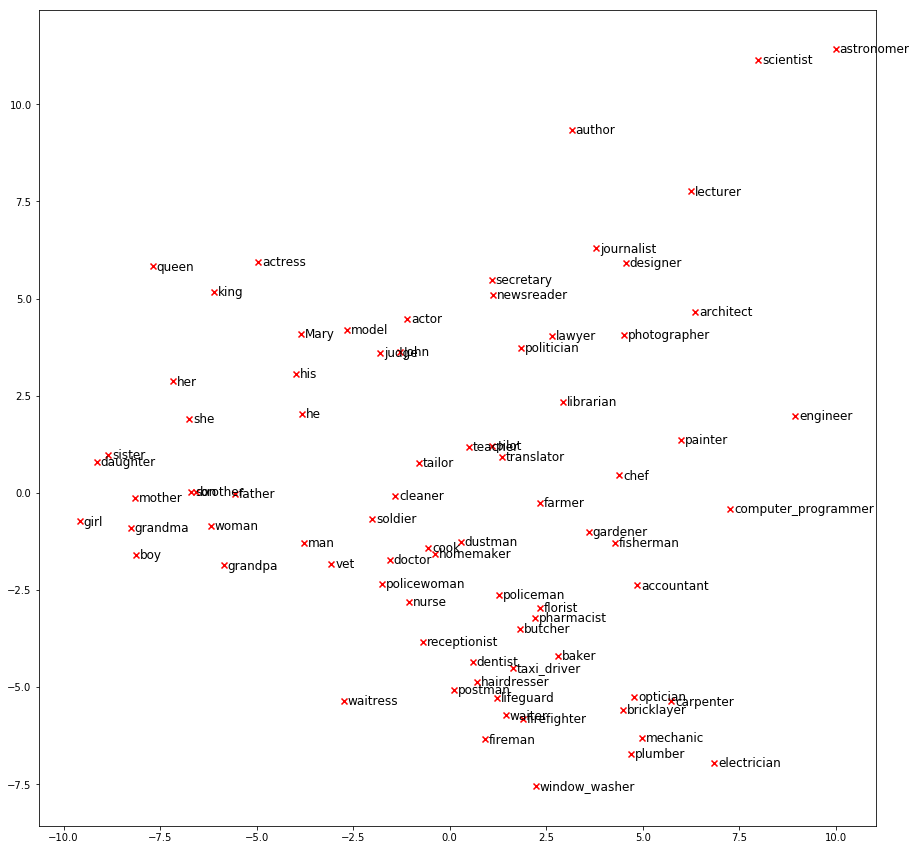

In [82]:
# List of random professions I got online, with some extra gender words
bias_words = ['accountant', 'actor', 'actress', 'architect', 'astronomer', 'author', 'baker', 'bricklayer', 
              'butcher', 'carpenter', 'chef', 'cook', 'cleaner', 'dentist', 'designer',
             'doctor', 'dustman', 'electrician', 'engineer',
             'farmer', 'fireman', 'firefighter', 'fisherman', 'florist', 'gardener', 'hairdresser',
             'journalist', 'judge', 'lawyer', 'lecturer', 'librarian', 'lifeguard', 'mechanic',
             'model', 'newsreader', 'nurse', 'optician', 'painter', 'pharmacist', 'photographer',
             'pilot', 'plumber', 'politician', 'policeman', 'policewoman', 'postman', 
             'receptionist', 'scientist', 'secretary', 'soldier', 'tailor', 'taxi_driver',
             'teacher', 'translator', 'vet', 'waiter', 'waitress',
             'window_washer', 'computer_programmer', 'homemaker']

# Optional: add gendered words:
bias_words = bias_words + super_gendered

# Calculating the bias
bias_pca = words_pca(bias_words, transform = 'pca')

# Plotting the PCA with words

for i,word in enumerate(bias_words):
    x = bias_pca[i,0]
    y = bias_pca[i,1]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.1, y-0.1, word, fontsize=12)
plt.show()

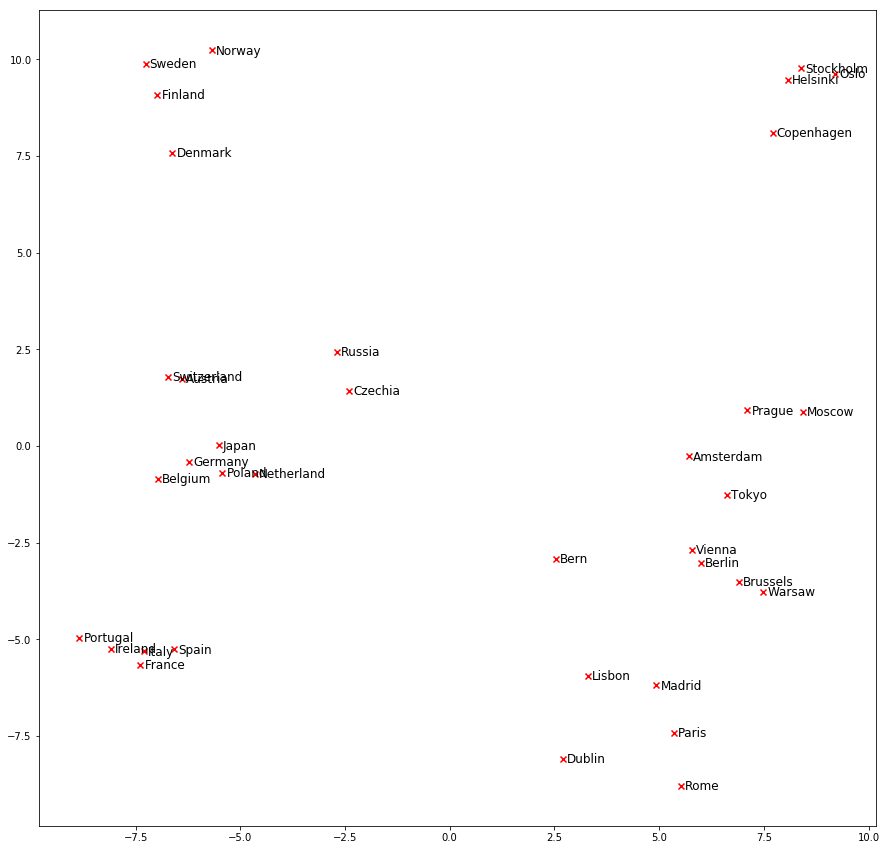

In [75]:
# Just wondering how countries behave
bias_words = ['Austria', 'Vienna', 'Belgium', 'Brussels', 'Czechia', 'Prague', 'Denmark', 'Copenhagen', 'Finland', 'Helsinki',
 'France', 'Paris', 'Germany', 'Berlin', 'Ireland', 'Dublin', 'Italy', 'Rome', 'Netherland', 'Amsterdam', 'Norway',
 'Oslo', 'Poland', 'Warsaw', 'Portugal', 'Lisbon', 'Russia', 'Moscow', 'Spain', 'Madrid', 'Sweden', 'Stockholm',
 'Switzerland', 'Bern']
# Optional: add gendered words:
#bias_words = bias_words + super_gendered

# Calculating the bias
bias_pca = words_pca(bias_words, transform = 'pca')

# Plotting the PCA with words

for i,word in enumerate(bias_words):
    x = bias_pca[i,0]
    y = bias_pca[i,1]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.1, y-0.1, word, fontsize=12)
plt.show()



In [48]:
# In case you want to add a new list of words
def check_in_word2vec(wordlist):
    checked_list = []
    for word in wordlist:
        if word in model.vocab:
            checked_list.append(word)
    return checked_list